## Post_Analysis1
This notebook analyzes prediction results. Note that target dams are selected by threshold of the Degree of Regulation (DOR) from the beggining.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import stats
import HydroErr as he
from tools import save_hdf
from itertools import compress

In [14]:
# Load prediction output files
mp1=[]; mp2=[]; mp3=[]; mp4=[]; mp5=[]
for i in range(1593):
    # Multiple file results
    filn = './data/chtc_out/dfFlowDams{}_manu.npz'.format(i)
    mp1.extend(np.load(filn,allow_pickle=True)['mp1'].tolist())
    mp2.extend(np.load(filn,allow_pickle=True)['mp2'].tolist())
    mp3.extend(np.load(filn,allow_pickle=True)['mp3'].tolist())
    mp4.extend(np.load(filn,allow_pickle=True)['mp4'].tolist())
    mp5.extend(np.load(filn,allow_pickle=True)['mp5'].tolist())
# Load predicted time-series and isFcst signs
dfMP1 = pd.read_hdf('./data/prediction/dfMP1.hdf')
dfMP2 = pd.read_hdf('./data/prediction/dfMP2.hdf')
dfMP3 = pd.read_hdf('./data/prediction/dfMP3.hdf')
dfMP4 = pd.read_hdf('./data/prediction/dfMP4.hdf')
dfMP5 = pd.read_hdf('./data/prediction/dfMP5.hdf')
dfMP1_sign = pd.read_hdf('./data/prediction/dfMP1_sign.hdf')
dfMP2_sign = pd.read_hdf('./data/prediction/dfMP2_sign.hdf')
dfMP3_sign = pd.read_hdf('./data/prediction/dfMP3_sign.hdf')
dfMP4_sign = pd.read_hdf('./data/prediction/dfMP4_sign.hdf')
dfMP5_sign = pd.read_hdf('./data/prediction/dfMP5_sign.hdf')
print('All results are loaded.')

All results are loaded.


In [22]:
# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('/Users/dlee/gdrive/gpower/data/dfFlowDams.hdf')
ind_dams = np.load('/Users/dlee/gdrive/gpower/data/ind_dams.npz')['ind_dams']
damList = ind_dams[0,:]

# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process...
dorx = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
dorx_ind = np.isin(damList, dorx.values)

# Select dams with DOR threshold
damList = damList[dorx_ind]
ndam = len(damList)
mp1_reduced = list(compress(mp1, dorx_ind))
mp2_reduced = list(compress(mp2, dorx_ind))
mp3_reduced = list(compress(mp3, dorx_ind))
mp4_reduced = list(compress(mp4, dorx_ind))
mp5_reduced = list(compress(mp5, dorx_ind))
dfMP1_sign_reduced = dfMP1_sign[dorx]
dfMP2_sign_reduced = dfMP2_sign[dorx]
dfMP3_sign_reduced = dfMP3_sign[dorx]
dfMP4_sign_reduced = dfMP4_sign[dorx]
dfMP5_sign_reduced = dfMP5_sign[dorx]
dfFlowDams = dfFlowDams[damList]
assert np.all([ybox['m01']['point_no'] for ybox in mp1_reduced] == damList)

In [86]:
oni_corr = np.full([12, ndam], np.nan)
oni_lead = oni_corr.copy()
oni_sign = oni_corr.copy()
nao_corr = oni_corr.copy()
nao_lead = oni_corr.copy()
nao_sign = oni_corr.copy()
pdo_corr = oni_corr.copy()
pdo_lead = oni_corr.copy()
pdo_sign = oni_corr.copy()
amo_corr = oni_corr.copy()
amo_lead = oni_corr.copy()
amo_sign = oni_corr.copy()
flow_corr = oni_corr.copy()
flow_lead = oni_corr.copy()
flow_sign = oni_corr.copy()
swvl_corr = oni_corr.copy()
swvl_lead = oni_corr.copy()
swvl_sign = oni_corr.copy()
snow_corr = oni_corr.copy()
snow_lead = oni_corr.copy()
snow_sign = oni_corr.copy()
for i in range(ndam):
    # Data preparation
    for m in range(1, 13):
        # MP1 --------------------- #
        mbox = mp1_reduced[i]['m%02d' % m].copy()
        if 'oni' in mbox['maxPred']:
            oni_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('oni')]
            oni_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('oni')]
            oni_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('oni')]
        if 'nao' in mbox['maxPred']:
            nao_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('nao')]
            nao_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('nao')]
            nao_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('nao')]
        if 'pdo' in mbox['maxPred']:
            pdo_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('pdo')]
            pdo_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('pdo')]
            pdo_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('pdo')]
        if 'amo' in mbox['maxPred']:
            amo_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('amo')]
            amo_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('amo')]
            amo_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('amo')]
        if 'flow' in mbox['maxPred']:
            flow_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('flow')]
            flow_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('flow')]
            flow_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('flow')]
        if 'swvl' in mbox['maxPred']:
            swvl_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('swvl')]
            swvl_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('swvl')]
            swvl_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('swvl')]
        if 'snow' in mbox['maxPred']:
            snow_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('snow')]
            snow_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('snow')]
            snow_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('snow')]

# SWVL and SNOW could be omitted during the algorithms due to multiple reasons, 
# such as monotonic value (all zero values).
swvl_sign[np.isnan(swvl_sign)] = 0
snow_sign[np.isnan(snow_sign)] = 0
data = np.vstack([np.sum(oni_sign == 1, 1),
                  np.sum(nao_sign == 1, 1),
                  np.sum(pdo_sign == 1, 1),
                  np.sum(amo_sign == 1, 1),
                  np.sum(flow_sign == 1, 1),
                  np.sum(swvl_sign == 1, 1),
                  np.sum(snow_sign == 1, 1)])

# Percentage of predcted dams
str_month = index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
str_variable = ['ENSO','NAO','PDO','AMO','FLOW','SM','SNOW']
dfPrctDams = pd.DataFrame(data, index=str_variable, columns=str_month)/ndam*100
# Number of months correlated with each predictor
NumMonCorr = np.vstack([oni_sign.sum(0),nao_sign.sum(0),amo_sign.sum(0),
                        pdo_sign.sum(0),flow_sign.sum(0),swvl_sign.sum(0),
                        snow_sign.sum(0)]).transpose()
NumMonCorr = pd.DataFrame(NumMonCorr,index=dfFlowDams.columns,columns=str_variable)
NumMonCorr.index.name = 'GRAND_ID'
# save_hdf('./data/NumMonCorr.hdf', NumMonCorr)

### Potential predictors and accuracy 

In [87]:
# Percentage of dams correlated dams across the year
print('Percentage of dams correlated dams across the year')
print(dfPrctDams.mean(1).round())

# Averaged number of predictors
AvgNumPred = oni_sign+nao_sign+pdo_sign+amo_sign+flow_sign+swvl_sign+snow_sign
AvgNumPred = AvgNumPred.mean(1).mean()
print('\nAveraged number of predictors: %.1f' % AvgNumPred)

if False:
    ### This requires above loop for all MP1-5_reduced
    # ['ENSO','NAO','PDO','AMO','FLOW','SM','SNOW']
    temp = (data5 / data1).mean(1).round(2)
    PrctRemain = pd.Series(temp, index = str_variable)
    print(PrctRemain)

Percentage of dams correlated dams across the year
ENSO    27.0
NAO     37.0
PDO     28.0
AMO     20.0
FLOW    72.0
SM      11.0
SNOW    25.0
dtype: float64

Averaged number of predictors: 2.2


In [88]:
# Averaged number of predicted months per each MP model
NumMonPred = pd.DataFrame(index = dfFlowDams.columns, columns=['NMON_MP1','NMON_MP2','NMON_MP3','NMON_MP4','NMON_MP5'])
NumMonPred['NMON_MP1'] = dfMP1_sign.sum(0)
NumMonPred['NMON_MP2'] = dfMP2_sign.sum(0)
NumMonPred['NMON_MP3'] = dfMP3_sign.sum(0)
NumMonPred['NMON_MP4'] = dfMP4_sign.sum(0)
NumMonPred['NMON_MP5'] = dfMP5_sign.sum(0)
print('Averaged number of predicted months per each MP model')
print(NumMonPred.mean().round(1))

Averaged number of predicted months per each MP model
NMON_MP1    8.1
NMON_MP2    7.0
NMON_MP3    6.2
NMON_MP4    5.8
NMON_MP5    5.2
dtype: float64


### KGE Score
Note that the original HydroErr.py is from BYU-Hydroinformatics. Plase visit https://github.com/BYU-Hydroinformatics/HydroErr for more details.

In [90]:
# Original KGE per MP model
nkge = np.zeros([ndam,5])
for (i, did) in enumerate(damList):
    # Normal KGE
    nkge[i,0] = he.kge_2012(dfMP1[did], dfFlowDams[did])
    nkge[i,1] = he.kge_2012(dfMP2[did], dfFlowDams[did])
    nkge[i,2] = he.kge_2012(dfMP3[did], dfFlowDams[did])
    nkge[i,3] = he.kge_2012(dfMP4[did], dfFlowDams[did])
    nkge[i,4] = he.kge_2012(dfMP5[did], dfFlowDams[did])
KGE = pd.DataFrame(nkge, index=dfFlowDams.columns, 
                   columns=['KGE_MP1','KGE_MP2','KGE_MP3','KGE_MP4','KGE_MP5'])

# Averaged KGE value per MP model
print('\nAveraged KGE values per MP model')
print(KGE.mean(0).round(2))
# Percent of dams with maximum KGE across all MP models
PrctMaxKGE = pd.value_counts(np.argmax(KGE.values, axis=1)).sort_index()/ndam*100
PrctMaxKGE.index = ['MP1', 'MP2', 'MP3', 'MP4', 'MP5']
print('\nPercent of dams with maximum KGE across all MP models')
print(PrctMaxKGE.round(0))
# Cross-correlation of KGE for all MP models
print('\nCross-correlation of KGE for all MP models')
print(KGE.corr().round(2))


# Save KGE Excel table
if False:
    KGE.to_excel('./data/prediction/kge.xlsx')
    print('./data/prediction/kge.xlsx is saved.')


Averaged KGE values per MP model
KGE_MP1    0.63
KGE_MP2    0.59
KGE_MP3    0.58
KGE_MP4    0.57
KGE_MP5    0.57
dtype: float64

Percent of dams with maximum KGE across all MP models
MP1    64.0
MP2    11.0
MP3     8.0
MP4     7.0
MP5    10.0
dtype: float64

Cross-correlation of KGE for all MP models
         KGE_MP1  KGE_MP2  KGE_MP3  KGE_MP4  KGE_MP5
KGE_MP1     1.00     0.96     0.93     0.91     0.88
KGE_MP2     0.96     1.00     0.98     0.96     0.94
KGE_MP3     0.93     0.98     1.00     0.98     0.97
KGE_MP4     0.91     0.96     0.98     1.00     0.99
KGE_MP5     0.88     0.94     0.97     0.99     1.00


#### DataFrame for mapping

In [33]:
subset = pd.merge(NumMonPred, KGE, left_index=True, right_index=True)
subset.index.name = 'GRAND_ID'
save_hdf('./data/subset.hdf', subset)
subset.head()

./data/subset.hdf is saved.


,NMON_MP1,NMON_MP2,NMON_MP3,NMON_MP4,NMON_MP5,KGE_MP1,KGE_MP2,KGE_MP3,KGE_MP4,KGE_MP5
GRAND_ID,,,,,,,,,,
6,10.0,8.0,6.0,7.0,5.0,0.771517,0.740698,0.726874,0.727000,0.724744
25,9.0,7.0,9.0,8.0,7.0,0.617319,0.564271,0.601437,0.615051,0.601788
27,6.0,3.0,6.0,5.0,5.0,0.609065,0.555172,0.574441,0.580823,0.570962
31,5.0,6.0,7.0,8.0,5.0,0.678594,0.682077,0.686184,0.713809,0.685329
35,6.0,8.0,7.0,6.0,5.0,0.402699,0.405489,0.394405,0.370539,0.369723


### (a) Percentage of dams correlated with each predictor per each month

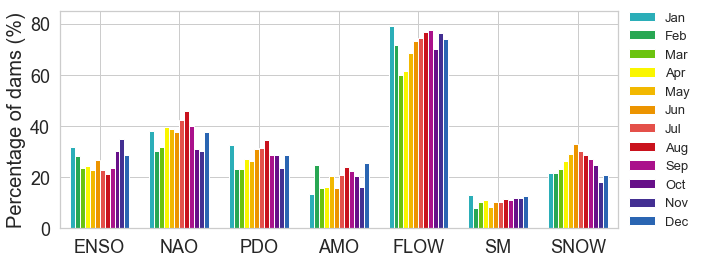

./figures/pdam_correlated.pdf is saved.


In [34]:
clist = ['#2BAEB8', '#28A753', '#6BC30F', '#FAF600', '#F2B800', '#EC9400', 
         '#E4504A', '#C9121D', '#AA118B', '#671089', '#432F92', '#2A65B2']
cmap = colors.ListedColormap(clist)

# MultiBar
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid")
ax = dfPrctDams.plot.bar(width=0.75, colormap=cmap)

# Parameters
ax.set_ylim([0,85])
ax.set_xlim([-0.5,6.5])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('Percentage of dams (%)', fontsize=20)
plt.xticks(range(0,7), dfPrctDams.index, rotation='horizontal')
ax.legend(loc='upper right',bbox_to_anchor=(1.15,1.05), fontsize=13, frameon=False)
plt.tight_layout
plt.show()

if True:
    fn_save = './figures/pdam_correlated.pdf'
    ax.figure.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)
    fn_save = './figures/pdam_correlated.png'
    ax.figure.savefig(fn_save, bbox_inches='tight')


In [9]:
np.arange(1,13) - np.nanmean(amo_lead, 1) + 12

array([ 7.7834275 ,  8.32140615,  9.68863779, 10.94475832, 11.89265537,
       12.76836158, 13.90709353, 15.19334589, 15.85561833, 16.34274953,
       17.52730697, 18.61644696])